In [ ]:
import os
import torch
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random
import json
from collections import defaultdict
from torch.optim.lr_scheduler import ReduceLROnPlateau
import heapq
import json
import re
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.patches as patches


In [ ]:
# import kagglehub

# # import kagglehub
# dataset_path = kagglehub.dataset_download('adityajn105/flickr8k')
# print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Example copy to your Google Drive
# !cp -r {dataset_path} /content/drive/MyDrive/dataSet/

In [ ]:
import os

flickr8k_Images = "/content/drive/My Drive/flickr8k/Images"

if os.path.exists(flickr8k_Images):
    print(" فایل در مسیر مشخص شده موجود است!")
else:
    print(" فایل یافت نشد! مسیر را بررسی کنید.")

 فایل در مسیر مشخص شده موجود است!


In [ ]:
resized_flickr8k_Images = [f for f in os.listdir(flickr8k_Images) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f'تعداد تصاویر موجود: {len(resized_flickr8k_Images)}')

تعداد تصاویر موجود: 8091


In [ ]:
caption_file = '/content/drive/My Drive/flickr8k/captions.txt'
df = pd.read_csv(caption_file)
print(df.head())

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [ ]:
print("تعداد کل کپشن‌ها:", len(df))

تعداد کل کپشن‌ها: 40455


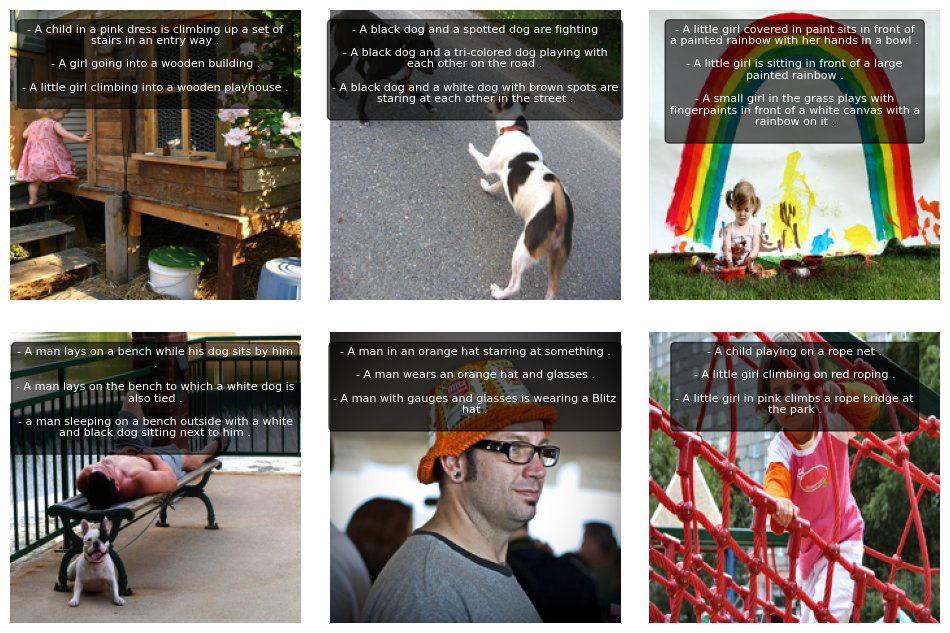

In [ ]:
df = pd.read_csv(caption_file)
captions_dict = df.groupby('image')['caption'].apply(list).to_dict()
selected_images = list(captions_dict.keys())[:6]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for idx, image_name in enumerate(selected_images):
    img_path = os.path.join(flickr8k_Images, image_name)
    if not os.path.exists(img_path):
        print(f"تصویر یافت نشد: {img_path}")
        continue
    img = Image.open(img_path).resize((224, 224))

    ax = axes[idx // 3, idx % 3]
    ax.imshow(img)
    ax.axis('off')
    captions = captions_dict[image_name][:3]
    wrapped_lines = []
    for cap in captions:
        wrapped = textwrap.wrap(f"- {cap}", width=50)
        wrapped_lines.extend(wrapped + [''])
    wrapped_caption = '\n'.join(wrapped_lines)
    ax.text(0.5, 0.95, wrapped_caption, fontsize=8, color='white',
            ha='center', va='top', transform=ax.transAxes,
            bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.4'))

plt.show()

#Image Preprosessing

In [ ]:
output_dir = '/content/drive/My Drive/flickr8k/flickr8k_224X224'
os.makedirs(output_dir, exist_ok=True)
image_files = [f for f in os.listdir(flickr8k_Images) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
for filename in tqdm(image_files, desc='Resizing and saving to Drive'):
    img_path = os.path.join(flickr8k_Images, filename)
    output_path = os.path.join(output_dir, filename)

    try:
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize((224, 224))
        img_resized.save(output_path, format='JPEG')
    except Exception as e:
        print(f"خطا در پردازش {filename}: {e}")

In [ ]:
resized_dir = '/content/drive/My Drive/flickr8k/flickr8k_224X224'
resized_images = [f for f in os.listdir(resized_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f'تعداد تصاویر موجود: {len(resized_images)}')

تعداد تصاویر موجود: 8091


In [ ]:
resized_dir = '/content/drive/My Drive/flickr8k/flickr8k_224X224'
class FlickrDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = FlickrDataset(resized_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
custome_mean = 0.
custome_std = 0.
nb_samples = 0.

for batch in tqdm(loader, desc="محاسبه میانگین و انحراف معیار"):
    batch_size = batch.size(0)
    batch = batch.view(batch_size, batch.size(1), -1)  # [B, C, H*W]
    custome_mean += batch.mean(2).sum(0)
    custome_std += batch.std(2).sum(0)
    nb_samples += batch_size

custome_mean /= nb_samples
custome_std /= nb_samples
print("\n میانگین نهایی هر کانال:", custome_mean)
print(" انحراف معیار نهایی هر کانال:", custome_std)

محاسبه میانگین و انحراف معیار: 100%|██████████| 253/253 [03:16<00:00,  1.29it/s]


 میانگین نهایی هر کانال: tensor([0.4580, 0.4461, 0.4042])
 انحراف معیار نهایی هر کانال: tensor([0.2323, 0.2245, 0.2281])


#Caption Preprosessing

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# def is_valid_caption(text):
#     return bool(text) and len(text.strip().split()) >= 2
df['caption'] = df['caption'].apply(preprocess_text)
#df = df[df['caption'].apply(is_valid_caption)].reset_index(drop=True)
captions = df['caption'].tolist()
special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
word_counter = Counter(word for caption in captions for word in caption.split())
vocab = special_tokens + sorted(word_counter.keys())
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
tokenizer_path = '/content/drive/My Drive/flickr8k/tokenizer_v1.json'
with open(tokenizer_path, 'w', encoding='utf-8') as f:
    json.dump(word2idx, f, ensure_ascii=False, indent=4)

print(f" tokenizer_v1.json ذخیره شد در: {tokenizer_path}")
print(f" اندازه واژگان نهایی: {len(vocab)}")


 tokenizer_v1.json ذخیره شد در: /content/drive/My Drive/flickr8k/tokenizer_v1.json
 اندازه واژگان نهایی: 8782


In [ ]:
idx2word = {idx: word for word, idx in word2idx.items()}

In [ ]:
tokenizer_path = '/content/drive/My Drive/flickr8k/tokenizer_v1.json'

In [ ]:
with open(tokenizer_path, 'w', encoding='utf-8') as f:
    json.dump(word2idx, f, ensure_ascii=False, indent=4)

print(f" فایل tokenizer_v1.json ذخیره شد در: {tokenizer_path}")
print(f" اندازه واژگان: {len(vocab)}")

 فایل tokenizer_v1.json ذخیره شد در: /content/drive/My Drive/flickr8k/tokenizer_v1.json
 اندازه واژگان: 8782


#Split Data

In [ ]:
image_dir = "/content/drive/My Drive/flickr8k/flickr8k_224X224"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.seed(42)
random.shuffle(image_files)
total = len(image_files)
train_size = int(0.8 * total)
val_size = int(0.1 * total)
test_size = total - train_size - val_size
train_images = image_files[:train_size]
val_images = image_files[train_size:train_size + val_size]
test_images = image_files[train_size + val_size:]
output_path = "/content/drive/My Drive/flickr8k"

with open(os.path.join(output_path, 'train_images.json'), 'w') as f:
    json.dump(train_images, f)

with open(os.path.join(output_path, 'val_images.json'), 'w') as f:
    json.dump(val_images, f)

with open(os.path.join(output_path, 'test_images.json'), 'w') as f:
    json.dump(test_images, f)
print(f"مجموع تصاویر: {total}")
print(f"آموزش (Train): {len(train_images)} تصویر")
print(f"اعتبارسنجی (Validation): {len(val_images)} تصویر")
print(f"تست (Test): {len(test_images)} تصویر")

مجموع تصاویر: 8091
آموزش (Train): 6472 تصویر
اعتبارسنجی (Validation): 809 تصویر
تست (Test): 810 تصویر


#Encoder

In [ ]:
embed_dim = 256
hidden_dim = 512
vocab_size = len(word2idx)
num_epochs = 40
batch_size = 32
learning_rate = 5e-4

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=7):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.output_dim = 2048

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, 2048)
        return features

#Decoder

In [ ]:
import torch
import torch.nn as nn
import random

class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(feature_dim + hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, features, hidden):
        hidden = hidden.permute(1, 0, 2)
        hidden = hidden.expand(-1, features.size(1), -1)
        concat = torch.cat((features, hidden), dim=2)
        energy = torch.tanh(self.attn(concat))
        attention = self.v(energy).squeeze(2)
        alpha = torch.softmax(attention, dim=1)
        context = torch.bmm(alpha.unsqueeze(1), features)
        return context.squeeze(1), alpha

class DecoderHybrid(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers=1, dropout_prob=0.5):
        super(DecoderHybrid, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.embed_dropout = nn.Dropout(dropout_prob)
        self.attention = Attention(2048, hidden_dim)

        self.lstm = nn.LSTM(embed_dim + 2048, hidden_dim, num_layers, batch_first=True)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_h = nn.Linear(2048, hidden_dim)
        self.init_c = nn.Linear(2048, hidden_dim)

    def forward(self, features, captions, teacher_forcing_ratio=1.0):
        batch_size, max_len = captions.size()
        device = captions.device

        h, c = self.init_hidden_states(features)

        inputs = captions[:, 0]
        outputs = torch.zeros(batch_size, max_len, self.vocab_size, device=device)

        for t in range(1, max_len):
            embedded = self.embed(inputs).unsqueeze(1)
            embedded = self.embed_dropout(embedded)

            context, _ = self.attention(features, h)
            lstm_input = torch.cat((embedded.squeeze(1), context), dim=1).unsqueeze(1)

            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            lstm_out = self.dropout(lstm_out)
            gru_out, _ = self.gru(lstm_out)
            gru_out = self.dropout(gru_out)

            output = self.linear(gru_out.squeeze(1))
            outputs[:, t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            inputs = captions[:, t] if teacher_force else top1

        return outputs

    def init_hidden_states(self, features):
        global_feat = features.mean(dim=1)
        h0 = self.init_h(global_feat).unsqueeze(0)
        c0 = self.init_c(global_feat).unsqueeze(0)
        return h0, c0

    def forward_step(self, prev_token, hidden, features):
        embedded = self.embed(prev_token).unsqueeze(1)
        embedded = self.embed_dropout(embedded)
        context, _ = self.attention(features, hidden[0])
        lstm_input = torch.cat((embedded.squeeze(1), context), dim=1).unsqueeze(1)
        lstm_out, (h, c) = self.lstm(lstm_input, hidden)
        lstm_out = self.dropout(lstm_out)
        gru_out, _ = self.gru(lstm_out)
        gru_out = self.dropout(gru_out)
        output = self.linear(gru_out.squeeze(1))
        return output, (h, c)


#End-to-End

In [ ]:
import torch
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(HybridModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, images, captions, teacher_forcing_ratio=0.5):
        feature_vectors = self.encoder(images)
        outputs = self.decoder(feature_vectors, captions, teacher_forcing_ratio)
        return outputs

#Train

In [ ]:
def tokenize_caption(caption, word2idx, max_length=20):
    tokens = caption.lower().split()
    tokens = ['<sos>'] + tokens + ['<eos>']
    token_ids = [word2idx.get(t, word2idx['<unk>']) for t in tokens]
    if len(token_ids) < max_length:
        token_ids += [word2idx['<pad>']] * (max_length - len(token_ids))
    else:
        token_ids = token_ids[:max_length]
    return token_ids

In [ ]:
class FlickrImageCaptionDataset(Dataset):
    def __init__(self, image_dir, image_list, captions_dict, word2idx, transform=None, max_length=20):
        self.image_dir = image_dir
        self.image_list = image_list
        self.captions_dict = captions_dict
        self.word2idx = word2idx
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_filename = self.image_list[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        caption = self.captions_dict[image_filename]
        tokens = tokenize_caption(caption, self.word2idx, self.max_length)
        caption_tensor = torch.tensor(tokens, dtype=torch.long)
        return image, caption_tensor, image_filename


In [ ]:
base_path = "/content/drive/My Drive/flickr8k"
image_dir = os.path.join(base_path, "flickr8k_224X224")
with open(os.path.join(base_path, 'train_images.json')) as f:
    train_images = json.load(f)
with open(os.path.join(base_path, 'val_images.json')) as f:
    val_images = json.load(f)
captions_dict = dict(df[['image', 'caption']].values)
with open(os.path.join(base_path, 'tokenizer_v1.json'), encoding='utf-8') as f:
    word2idx = json.load(f)

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(custome_mean, custome_std)
])
train_dataset = FlickrImageCaptionDataset(
    image_dir=image_dir,
    image_list=train_images,
    captions_dict=captions_dict,
    word2idx=word2idx,
    transform=transform_train
)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(custome_mean, custome_std)
])
val_dataset = FlickrImageCaptionDataset(
    image_dir=image_dir,
    image_list=val_images,
    captions_dict=captions_dict,
    word2idx=word2idx,
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
V = vocab_size = len(word2idx)
print(V)

8782


In [ ]:
def compute_bleu_scores(candidate, references):
    smoothie = SmoothingFunction().method4
    references = [ref.lower().split() for ref in references]

    if isinstance(candidate, str):
        candidate = candidate.lower().split()
    scores = [
        sentence_bleu(references, candidate, weights=w, smoothing_function=smoothie)
        for w in [(1, 0, 0, 0), (0.5, 0.5, 0, 0), (1/3, 1/3, 1/3, 0), (0.25, 0.25, 0.25, 0.25)]
    ]
    return scores


In [ ]:
gt_captions = defaultdict(list)
for _, row in df.iterrows():
    filename = row['image']
    caption = row['caption'].strip()
    gt_captions[filename].append(caption)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, device, teacher_forcing_start=1.0, teacher_forcing_end=0.5):
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    train_acc_per_epoch = []
    val_acc_per_epoch = []
    best_val_loss = float('inf')

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = 0.0
        train_total = 0
        train_correct = 0
        teacher_forcing_ratio = teacher_forcing_start - (epoch / num_epochs) * (teacher_forcing_start - teacher_forcing_end)

        pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for images, captions, filenames in pbar:
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()
            outputs = model(images, captions, teacher_forcing_ratio=teacher_forcing_ratio)
            targets = captions

            loss = criterion(outputs[:, 1:].reshape(-1, outputs.shape[-1]), targets[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

            preds = outputs.argmax(dim=-1)
            mask = targets != 0
            train_correct += (preds == targets)[mask].sum().item()
            train_total += mask.sum().item()
            current_loss = train_epoch_loss / (pbar.n + 1)
            current_acc = train_correct / (train_total + 1e-8)
            pbar.set_postfix({"Loss": f"{current_loss:.4f}", "Acc": f"{current_acc:.4f}"})

        avg_train_loss = train_epoch_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        train_loss_per_epoch.append(avg_train_loss)
        train_acc_per_epoch.append(train_accuracy)

        # ------------------- VALIDATION -------------------
        model.eval()
        val_epoch_loss = 0.0
        val_total = 0
        val_correct = 0

        bleu1_total = bleu2_total = bleu3_total = bleu4_total = 0
        bleu_count = 0

        with torch.no_grad():
            for i, (images, captions, filenames) in enumerate(val_loader):
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions, teacher_forcing_ratio=1.0)
                targets = captions

                loss = criterion(outputs[:, 1:].reshape(-1, outputs.shape[-1]), targets[:, 1:].reshape(-1))
                val_epoch_loss += loss.item()

                preds = outputs.argmax(dim=-1)
                mask = targets != 0
                val_correct += (preds == targets)[mask].sum().item()
                val_total += mask.sum().item()

                # BLEU
                for j in range(images.size(0)):
                    filename_idx = i * val_loader.batch_size + j
                    if filename_idx < len(filenames):
                        filename = filenames[filename_idx]
                        if filename in gt_captions:
                            img_tensor = images[j].unsqueeze(0)
                            candidate = greedy_search(model, img_tensor.squeeze(0), word2idx, idx2word)
                            references = gt_captions[filename][:3]

                            b1, b2, b3, b4 = compute_bleu_scores(candidate, references)
                            bleu1_total += b1
                            bleu2_total += b2
                            bleu3_total += b3
                            bleu4_total += b4
                            bleu_count += 1

        avg_val_loss = val_epoch_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_loss_per_epoch.append(avg_val_loss)
        val_acc_per_epoch.append(val_accuracy)

        bleu1 = bleu1_total / max(bleu_count, 1)
        bleu2 = bleu2_total / max(bleu_count, 1)
        bleu3 = bleu3_total / max(bleu_count, 1)
        bleu4 = bleu4_total / max(bleu_count, 1)

        scheduler.step(avg_val_loss)

        print(f" BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f} | Teacher Forcing: {teacher_forcing_ratio:.2f}")
        print(f"Epoch {epoch+1} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/drive/My Drive/flickr8k/best_model_scheduled.pth')
            print(" مدل بهتر ذخیره شد")

        torch.save(model.state_dict(), '/content/drive/My Drive/flickr8k/last_model_scheduled.pth')

    return train_loss_per_epoch, val_loss_per_epoch, train_acc_per_epoch, val_acc_per_epoch


In [ ]:
def plot_loss_and_accuracy(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', color='green')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
encoder = EncoderCNN()
decoder = DecoderHybrid(embed_dim, hidden_dim, vocab_size)
model = HybridModel(encoder, decoder)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=word2idx['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch [1/40]: 100%|██████████| 203/203 [01:41<00:00,  2.00it/s, Loss=6.0840, Acc=0.1197]


 BLEU-1: 0.4502, BLEU-2: 0.1426, BLEU-3: 0.0737, BLEU-4: 0.0473
Epoch [1/40] | Train Loss: 6.0840, Acc: 0.1197 | Val Loss: 5.4884, Acc: 0.1724 | Teacher Forcing: 1.00
Epoch 1 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [2/40]: 100%|██████████| 203/203 [01:42<00:00,  1.98it/s, Loss=5.3609, Acc=0.1848]


 BLEU-1: 0.3595, BLEU-2: 0.1585, BLEU-3: 0.0838, BLEU-4: 0.0528
Epoch [2/40] | Train Loss: 5.3609, Acc: 0.1848 | Val Loss: 5.0208, Acc: 0.2192 | Teacher Forcing: 0.99
Epoch 2 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [3/40]: 100%|██████████| 203/203 [01:49<00:00,  1.85it/s, Loss=5.1000, Acc=0.2118]


 BLEU-1: 0.2969, BLEU-2: 0.1602, BLEU-3: 0.0950, BLEU-4: 0.0632
Epoch [3/40] | Train Loss: 5.1000, Acc: 0.2118 | Val Loss: 4.8522, Acc: 0.2434 | Teacher Forcing: 0.97
Epoch 3 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [4/40]: 100%|██████████| 203/203 [01:49<00:00,  1.86it/s, Loss=4.9501, Acc=0.2251]


 BLEU-1: 0.3058, BLEU-2: 0.1230, BLEU-3: 0.0657, BLEU-4: 0.0425
Epoch [4/40] | Train Loss: 4.9501, Acc: 0.2251 | Val Loss: 4.7328, Acc: 0.2541 | Teacher Forcing: 0.96
Epoch 4 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [5/40]: 100%|██████████| 203/203 [01:50<00:00,  1.84it/s, Loss=4.8568, Acc=0.2325]


 BLEU-1: 0.3170, BLEU-2: 0.1345, BLEU-3: 0.0688, BLEU-4: 0.0427
Epoch [5/40] | Train Loss: 4.8568, Acc: 0.2325 | Val Loss: 4.6417, Acc: 0.2649 | Teacher Forcing: 0.95
Epoch 5 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [6/40]: 100%|██████████| 203/203 [01:50<00:00,  1.83it/s, Loss=4.7823, Acc=0.2401]


 BLEU-1: 0.3226, BLEU-2: 0.1246, BLEU-3: 0.0625, BLEU-4: 0.0385
Epoch [6/40] | Train Loss: 4.7823, Acc: 0.2401 | Val Loss: 4.5641, Acc: 0.2720 | Teacher Forcing: 0.94
Epoch 6 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [7/40]: 100%|██████████| 203/203 [01:50<00:00,  1.84it/s, Loss=4.7324, Acc=0.2427]


 BLEU-1: 0.3071, BLEU-2: 0.1276, BLEU-3: 0.0689, BLEU-4: 0.0449
Epoch [7/40] | Train Loss: 4.7324, Acc: 0.2427 | Val Loss: 4.5224, Acc: 0.2691 | Teacher Forcing: 0.93
Epoch 7 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [8/40]: 100%|██████████| 203/203 [01:50<00:00,  1.84it/s, Loss=4.6851, Acc=0.2459]


 BLEU-1: 0.2845, BLEU-2: 0.1069, BLEU-3: 0.0548, BLEU-4: 0.0343
Epoch [8/40] | Train Loss: 4.6851, Acc: 0.2459 | Val Loss: 4.5034, Acc: 0.2758 | Teacher Forcing: 0.91
Epoch 8 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [9/40]: 100%|██████████| 203/203 [01:49<00:00,  1.85it/s, Loss=4.6252, Acc=0.2521]


 BLEU-1: 0.2977, BLEU-2: 0.1157, BLEU-3: 0.0648, BLEU-4: 0.0430
Epoch [9/40] | Train Loss: 4.6252, Acc: 0.2521 | Val Loss: 4.4440, Acc: 0.2868 | Teacher Forcing: 0.90
Epoch 9 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [10/40]: 100%|██████████| 203/203 [01:49<00:00,  1.86it/s, Loss=4.6259, Acc=0.2518]


 BLEU-1: 0.2834, BLEU-2: 0.1071, BLEU-3: 0.0581, BLEU-4: 0.0367
Epoch [10/40] | Train Loss: 4.6259, Acc: 0.2518 | Val Loss: 4.4225, Acc: 0.2859 | Teacher Forcing: 0.89
Epoch 10 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [11/40]: 100%|██████████| 203/203 [01:50<00:00,  1.84it/s, Loss=4.5984, Acc=0.2530]


 BLEU-1: 0.2729, BLEU-2: 0.1130, BLEU-3: 0.0614, BLEU-4: 0.0391
Epoch [11/40] | Train Loss: 4.5984, Acc: 0.2530 | Val Loss: 4.4094, Acc: 0.2878 | Teacher Forcing: 0.88
Epoch 11 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [12/40]: 100%|██████████| 203/203 [01:50<00:00,  1.84it/s, Loss=4.6125, Acc=0.2504]


 BLEU-1: 0.3319, BLEU-2: 0.1405, BLEU-3: 0.0773, BLEU-4: 0.0487
Epoch [12/40] | Train Loss: 4.6125, Acc: 0.2504 | Val Loss: 4.3980, Acc: 0.2900 | Teacher Forcing: 0.86
Epoch 12 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [13/40]: 100%|██████████| 203/203 [01:50<00:00,  1.83it/s, Loss=4.5715, Acc=0.2549]


 BLEU-1: 0.2929, BLEU-2: 0.1231, BLEU-3: 0.0653, BLEU-4: 0.0416
Epoch [13/40] | Train Loss: 4.5715, Acc: 0.2549 | Val Loss: 4.3900, Acc: 0.2916 | Teacher Forcing: 0.85
Epoch 13 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [14/40]: 100%|██████████| 203/203 [01:50<00:00,  1.84it/s, Loss=4.5688, Acc=0.2541]


 BLEU-1: 0.3296, BLEU-2: 0.1328, BLEU-3: 0.0723, BLEU-4: 0.0465
Epoch [14/40] | Train Loss: 4.5688, Acc: 0.2541 | Val Loss: 4.3754, Acc: 0.2944 | Teacher Forcing: 0.84
Epoch 14 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [15/40]: 100%|██████████| 203/203 [01:49<00:00,  1.85it/s, Loss=4.5861, Acc=0.2492]


 BLEU-1: 0.2843, BLEU-2: 0.1154, BLEU-3: 0.0612, BLEU-4: 0.0393
Epoch [15/40] | Train Loss: 4.5861, Acc: 0.2492 | Val Loss: 4.3618, Acc: 0.2936 | Teacher Forcing: 0.82
Epoch 15 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [16/40]: 100%|██████████| 203/203 [01:49<00:00,  1.85it/s, Loss=4.5446, Acc=0.2549]


 BLEU-1: 0.3237, BLEU-2: 0.1168, BLEU-3: 0.0608, BLEU-4: 0.0385
Epoch [16/40] | Train Loss: 4.5446, Acc: 0.2549 | Val Loss: 4.3506, Acc: 0.2933 | Teacher Forcing: 0.81
Epoch 16 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [17/40]: 100%|██████████| 203/203 [01:49<00:00,  1.85it/s, Loss=4.5263, Acc=0.2563]


 BLEU-1: 0.2800, BLEU-2: 0.1144, BLEU-3: 0.0631, BLEU-4: 0.0416
Epoch [17/40] | Train Loss: 4.5263, Acc: 0.2563 | Val Loss: 4.3380, Acc: 0.2910 | Teacher Forcing: 0.80
Epoch 17 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [18/40]: 100%|██████████| 203/203 [01:49<00:00,  1.85it/s, Loss=4.5624, Acc=0.2533]


 BLEU-1: 0.3081, BLEU-2: 0.1387, BLEU-3: 0.0783, BLEU-4: 0.0501
Epoch [18/40] | Train Loss: 4.5624, Acc: 0.2533 | Val Loss: 4.3510, Acc: 0.2949 | Teacher Forcing: 0.79
Epoch 18 | LR: 0.000500


Epoch [19/40]: 100%|██████████| 203/203 [01:45<00:00,  1.93it/s, Loss=4.5337, Acc=0.2534]


 BLEU-1: 0.2716, BLEU-2: 0.1179, BLEU-3: 0.0629, BLEU-4: 0.0407
Epoch [19/40] | Train Loss: 4.5337, Acc: 0.2534 | Val Loss: 4.3228, Acc: 0.2984 | Teacher Forcing: 0.78
Epoch 19 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [20/40]: 100%|██████████| 203/203 [01:51<00:00,  1.83it/s, Loss=4.5315, Acc=0.2540]


 BLEU-1: 0.3203, BLEU-2: 0.1225, BLEU-3: 0.0636, BLEU-4: 0.0403
Epoch [20/40] | Train Loss: 4.5315, Acc: 0.2540 | Val Loss: 4.3229, Acc: 0.3021 | Teacher Forcing: 0.76
Epoch 20 | LR: 0.000500


Epoch [21/40]: 100%|██████████| 203/203 [01:43<00:00,  1.97it/s, Loss=4.5311, Acc=0.2531]


 BLEU-1: 0.3189, BLEU-2: 0.1250, BLEU-3: 0.0687, BLEU-4: 0.0452
Epoch [21/40] | Train Loss: 4.5311, Acc: 0.2531 | Val Loss: 4.3140, Acc: 0.3009 | Teacher Forcing: 0.75
Epoch 21 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [22/40]: 100%|██████████| 203/203 [01:47<00:00,  1.89it/s, Loss=4.5380, Acc=0.2519]


 BLEU-1: 0.3419, BLEU-2: 0.1273, BLEU-3: 0.0685, BLEU-4: 0.0429
Epoch [22/40] | Train Loss: 4.5380, Acc: 0.2519 | Val Loss: 4.3148, Acc: 0.2987 | Teacher Forcing: 0.74
Epoch 22 | LR: 0.000500


Epoch [23/40]: 100%|██████████| 203/203 [01:44<00:00,  1.94it/s, Loss=4.5515, Acc=0.2499]


 BLEU-1: 0.3485, BLEU-2: 0.1378, BLEU-3: 0.0752, BLEU-4: 0.0494
Epoch [23/40] | Train Loss: 4.5515, Acc: 0.2499 | Val Loss: 4.3199, Acc: 0.2996 | Teacher Forcing: 0.72
Epoch 23 | LR: 0.000500


Epoch [24/40]: 100%|██████████| 203/203 [01:44<00:00,  1.95it/s, Loss=4.5377, Acc=0.2516]


 BLEU-1: 0.3368, BLEU-2: 0.1341, BLEU-3: 0.0711, BLEU-4: 0.0459
Epoch [24/40] | Train Loss: 4.5377, Acc: 0.2516 | Val Loss: 4.3062, Acc: 0.3024 | Teacher Forcing: 0.71
Epoch 24 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [25/40]: 100%|██████████| 203/203 [01:48<00:00,  1.87it/s, Loss=4.5456, Acc=0.2477]


 BLEU-1: 0.3376, BLEU-2: 0.1335, BLEU-3: 0.0716, BLEU-4: 0.0457
Epoch [25/40] | Train Loss: 4.5456, Acc: 0.2477 | Val Loss: 4.3089, Acc: 0.3049 | Teacher Forcing: 0.70
Epoch 25 | LR: 0.000500


Epoch [26/40]: 100%|██████████| 203/203 [01:44<00:00,  1.94it/s, Loss=4.5569, Acc=0.2493]


 BLEU-1: 0.3263, BLEU-2: 0.1276, BLEU-3: 0.0680, BLEU-4: 0.0440
Epoch [26/40] | Train Loss: 4.5569, Acc: 0.2493 | Val Loss: 4.3026, Acc: 0.3055 | Teacher Forcing: 0.69
Epoch 26 | LR: 0.000500
 مدل بهتر ذخیره شد


Epoch [27/40]: 100%|██████████| 203/203 [01:47<00:00,  1.88it/s, Loss=4.5781, Acc=0.2456]


 BLEU-1: 0.3428, BLEU-2: 0.1556, BLEU-3: 0.0895, BLEU-4: 0.0587
Epoch [27/40] | Train Loss: 4.5781, Acc: 0.2456 | Val Loss: 4.3038, Acc: 0.3018 | Teacher Forcing: 0.68
Epoch 27 | LR: 0.000500


Epoch [28/40]: 100%|██████████| 203/203 [01:44<00:00,  1.94it/s, Loss=4.5636, Acc=0.2457]


 BLEU-1: 0.3577, BLEU-2: 0.1569, BLEU-3: 0.0860, BLEU-4: 0.0539
Epoch [28/40] | Train Loss: 4.5636, Acc: 0.2457 | Val Loss: 4.3204, Acc: 0.3026 | Teacher Forcing: 0.66
Epoch 28 | LR: 0.000500


Epoch [29/40]: 100%|██████████| 203/203 [01:47<00:00,  1.89it/s, Loss=4.5756, Acc=0.2453]


 BLEU-1: 0.3384, BLEU-2: 0.1394, BLEU-3: 0.0723, BLEU-4: 0.0463
Epoch [29/40] | Train Loss: 4.5756, Acc: 0.2453 | Val Loss: 4.3079, Acc: 0.3027 | Teacher Forcing: 0.65
Epoch 29 | LR: 0.000500


Epoch [30/40]: 100%|██████████| 203/203 [01:50<00:00,  1.84it/s, Loss=4.5816, Acc=0.2435]


 BLEU-1: 0.3456, BLEU-2: 0.1421, BLEU-3: 0.0801, BLEU-4: 0.0528
Epoch [30/40] | Train Loss: 4.5816, Acc: 0.2435 | Val Loss: 4.3104, Acc: 0.3063 | Teacher Forcing: 0.64
Epoch 30 | LR: 0.000250


Epoch [31/40]: 100%|██████████| 203/203 [01:48<00:00,  1.87it/s, Loss=4.5790, Acc=0.2422]


 BLEU-1: 0.3257, BLEU-2: 0.1384, BLEU-3: 0.0764, BLEU-4: 0.0494
Epoch [31/40] | Train Loss: 4.5790, Acc: 0.2422 | Val Loss: 4.3051, Acc: 0.3048 | Teacher Forcing: 0.62
Epoch 31 | LR: 0.000250


Epoch [32/40]: 100%|██████████| 203/203 [01:48<00:00,  1.87it/s, Loss=4.5950, Acc=0.2398]


 BLEU-1: 0.3719, BLEU-2: 0.1542, BLEU-3: 0.0814, BLEU-4: 0.0517
Epoch [32/40] | Train Loss: 4.5950, Acc: 0.2398 | Val Loss: 4.2979, Acc: 0.3059 | Teacher Forcing: 0.61
Epoch 32 | LR: 0.000250
 مدل بهتر ذخیره شد


Epoch [33/40]: 100%|██████████| 203/203 [01:58<00:00,  1.72it/s, Loss=4.6007, Acc=0.2411]


 BLEU-1: 0.3971, BLEU-2: 0.1819, BLEU-3: 0.1023, BLEU-4: 0.0635
Epoch [33/40] | Train Loss: 4.6007, Acc: 0.2411 | Val Loss: 4.2942, Acc: 0.3073 | Teacher Forcing: 0.60
Epoch 33 | LR: 0.000250
 مدل بهتر ذخیره شد


Epoch [34/40]: 100%|██████████| 203/203 [01:51<00:00,  1.82it/s, Loss=4.6034, Acc=0.2384]


 BLEU-1: 0.3829, BLEU-2: 0.1688, BLEU-3: 0.1003, BLEU-4: 0.0647
Epoch [34/40] | Train Loss: 4.6034, Acc: 0.2384 | Val Loss: 4.2978, Acc: 0.3057 | Teacher Forcing: 0.59
Epoch 34 | LR: 0.000250


Epoch [35/40]: 100%|██████████| 203/203 [01:44<00:00,  1.94it/s, Loss=4.6398, Acc=0.2347]


 BLEU-1: 0.3627, BLEU-2: 0.1557, BLEU-3: 0.0881, BLEU-4: 0.0559
Epoch [35/40] | Train Loss: 4.6398, Acc: 0.2347 | Val Loss: 4.2978, Acc: 0.3078 | Teacher Forcing: 0.57
Epoch 35 | LR: 0.000250


Epoch [36/40]: 100%|██████████| 203/203 [01:45<00:00,  1.92it/s, Loss=4.6432, Acc=0.2350]


 BLEU-1: 0.3769, BLEU-2: 0.1574, BLEU-3: 0.0803, BLEU-4: 0.0509
Epoch [36/40] | Train Loss: 4.6432, Acc: 0.2350 | Val Loss: 4.3010, Acc: 0.3087 | Teacher Forcing: 0.56
Epoch 36 | LR: 0.000250


Epoch [37/40]: 100%|██████████| 203/203 [01:51<00:00,  1.82it/s, Loss=4.6210, Acc=0.2364]


 BLEU-1: 0.3844, BLEU-2: 0.1600, BLEU-3: 0.0925, BLEU-4: 0.0600
Epoch [37/40] | Train Loss: 4.6210, Acc: 0.2364 | Val Loss: 4.3001, Acc: 0.3061 | Teacher Forcing: 0.55
Epoch 37 | LR: 0.000125


Epoch [38/40]: 100%|██████████| 203/203 [01:50<00:00,  1.83it/s, Loss=4.6578, Acc=0.2313]


 BLEU-1: 0.3796, BLEU-2: 0.1744, BLEU-3: 0.0968, BLEU-4: 0.0627
Epoch [38/40] | Train Loss: 4.6578, Acc: 0.2313 | Val Loss: 4.3005, Acc: 0.3084 | Teacher Forcing: 0.54
Epoch 38 | LR: 0.000125


Epoch [39/40]: 100%|██████████| 203/203 [01:43<00:00,  1.96it/s, Loss=4.6565, Acc=0.2326]


 BLEU-1: 0.3676, BLEU-2: 0.1548, BLEU-3: 0.0834, BLEU-4: 0.0548
Epoch [39/40] | Train Loss: 4.6565, Acc: 0.2326 | Val Loss: 4.3012, Acc: 0.3083 | Teacher Forcing: 0.53
Epoch 39 | LR: 0.000125


Epoch [40/40]: 100%|██████████| 203/203 [01:44<00:00,  1.95it/s, Loss=4.6590, Acc=0.2295]


 BLEU-1: 0.3630, BLEU-2: 0.1626, BLEU-3: 0.0856, BLEU-4: 0.0539
Epoch [40/40] | Train Loss: 4.6590, Acc: 0.2295 | Val Loss: 4.2973, Acc: 0.3079 | Teacher Forcing: 0.51
Epoch 40 | LR: 0.000125


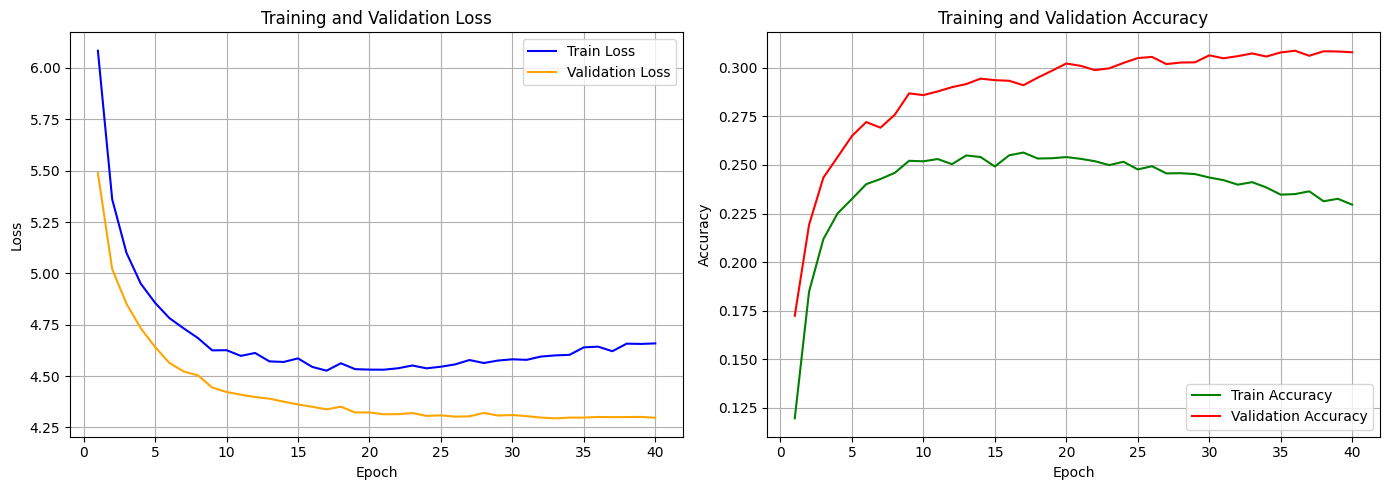

In [ ]:
train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    num_epochs=40,
    device=device,
    teacher_forcing_start=1.0,
    teacher_forcing_end=0.5
)

plot_loss_and_accuracy(train_loss, val_loss, train_acc, val_acc)

In [ ]:
encoder = EncoderCNN()
decoder = DecoderHybrid(embed_dim, hidden_dim, vocab_size)
model = HybridModel(encoder, decoder)

load_path = '/content/drive/My Drive/flickr8k/best_model_scheduled.pth'
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()
print(" مدل با موفقیت بارگذاری شد.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 مدل با موفقیت بارگذاری شد.


#Evaluation

#Greedy Search

In [ ]:
def greedy_search(model, image_tensor, word2idx, idx2word, max_len=20, avoid_repetition=True):
    model.eval()

    # آماده‌سازی تصویر و استخراج ویژگی‌ها
    image_tensor = image_tensor.unsqueeze(0)  # (1, 3, 224, 224)
    features = model.encoder(image_tensor)    # (1, 49, 2048)
    h, c = model.decoder.init_hidden_states(features)

    input_token = torch.tensor([word2idx['<sos>']], device=image_tensor.device)
    generated_ids = []

    for _ in range(max_len):
        output, (h, c) = model.decoder.forward_step(input_token, (h, c), features)
        probs = torch.softmax(output, dim=-1).squeeze(0)  # (V,)

        if avoid_repetition and generated_ids:
            # جلوگیری از تکرار متوالی (تا دو توکن آخر)
            for prev_id in generated_ids[-2:]:
                probs[prev_id] = 0.0

        predicted_id = torch.argmax(probs).item()

        if predicted_id == word2idx['<eos>']:
            break

        generated_ids.append(predicted_id)
        input_token = torch.tensor([predicted_id], device=image_tensor.device)

    generated_words = [idx2word.get(i, "<unk>") for i in generated_ids]
    return ' '.join(generated_words)


#Beam Search

In [ ]:
def beam_search(model, image_tensor, word2idx, idx2word, beam_width=5, max_len=20, repetition_penalty=1.2):
    model.eval()

    image_tensor = image_tensor.unsqueeze(0)
    features = model.encoder(image_tensor)
    h, c = model.decoder.init_hidden_states(features)

    sos_id = word2idx['<sos>']
    eos_id = word2idx['<eos>']
    sequences = [(0.0, [sos_id], (h, c))]

    for _ in range(max_len):
        all_candidates = []

        for score, seq, (h, c) in sequences:
            input_token = torch.tensor([seq[-1]], device=image_tensor.device)
            output, (h_new, c_new) = model.decoder.forward_step(input_token, (h, c), features)

            probs = torch.log_softmax(output, dim=-1).squeeze(0)
            topk = torch.topk(probs, beam_width)

            for i in range(beam_width):
                token_id = topk.indices[i].item()
                token_score = topk.values[i].item()

                if token_id in seq:
                    token_score -= repetition_penalty

                new_seq = seq + [token_id]
                new_score = score + token_score
                all_candidates.append((new_score, new_seq, (h_new, c_new)))

        sequences = sorted(all_candidates, key=lambda tup: tup[0] / len(tup[1]), reverse=True)[:beam_width]

        if all(seq[-1] == eos_id for _, seq, _ in sequences):
            break

    final_seq = sequences[0][1]
    result_tokens = []
    for idx in final_seq[1:]:  # skip <sos>
        if idx == eos_id:
            break
        result_tokens.append(idx2word.get(idx, "<unk>"))

    return ' '.join(result_tokens)


#Display 5 Images with caption

In [ ]:
with open('/content/drive/My Drive/flickr8k/test_images.json', 'r') as f:
    test_image_files = json.load(f)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import textwrap
from PIL import Image

def display_images(model, image_paths, transform, word2idx, idx2word, gt_captions, device, bleu_threshold=0.2, max_unk=2):
    model.eval()
    num_images = len(image_paths)
    rows, cols = 2, 3
    fig = plt.figure(figsize=(cols * 5, rows * 6))
    spec = gridspec.GridSpec(rows * 2, cols, figure=fig, height_ratios=[3, 1] * rows)

    for idx in range(num_images):
        img_row = (idx // cols) * 2
        col = idx % cols

        # Image axis
        ax_img = fig.add_subplot(spec[img_row, col])
        ax_img.axis('off')

        path = image_paths[idx]
        image = Image.open(path).convert("RGB").resize((224, 224))
        img_tensor = transform(image).unsqueeze(0).to(device)

        greedy_cap = greedy_search(model, img_tensor.squeeze(0), word2idx, idx2word)
        beam_cap = beam_search(model, img_tensor.squeeze(0), word2idx, idx2word, beam_width=5)

        filename = path.split('/')[-1]
        references = gt_captions.get(filename, ["(No ground truth)"])

        b1, b2, b3, b4 = compute_bleu_scores(greedy_cap, references)
        tokens = greedy_cap.split()
        real_words = [t for t in tokens if t not in ['<sos>', '<eos>', '<pad>']]
        unk_count = tokens.count('<unk>')
        is_failed = b4 < bleu_threshold or unk_count > max_unk or len(real_words) < 3

        ax_img.imshow(image)

        # Text box axis below
        ax_text = fig.add_subplot(spec[img_row + 1, col])
        ax_text.axis('off')
        ax_text.set_facecolor('white')

        greedy_text = textwrap.fill(f"Greedy: {greedy_cap}", width=50)
        beam_text = textwrap.fill(f"Beam: {beam_cap}", width=50)
        true_text = textwrap.fill(f"True: {references[0]}", width=50)
        bleu_text = f"BLEU1-4: {b1:.2f}, {b2:.2f}, {b3:.2f}, {b4:.2f}"
        failure_text = " Failure" if is_failed else " OK"

        full_caption = f"{greedy_text}\n{beam_text}\n{true_text}\n{bleu_text}\n{failure_text}"
        ax_text.text(0, 1, full_caption,  fontsize = 8.5 , va='top', ha='left', wrap=True)

    plt.tight_layout()
    plt.show()


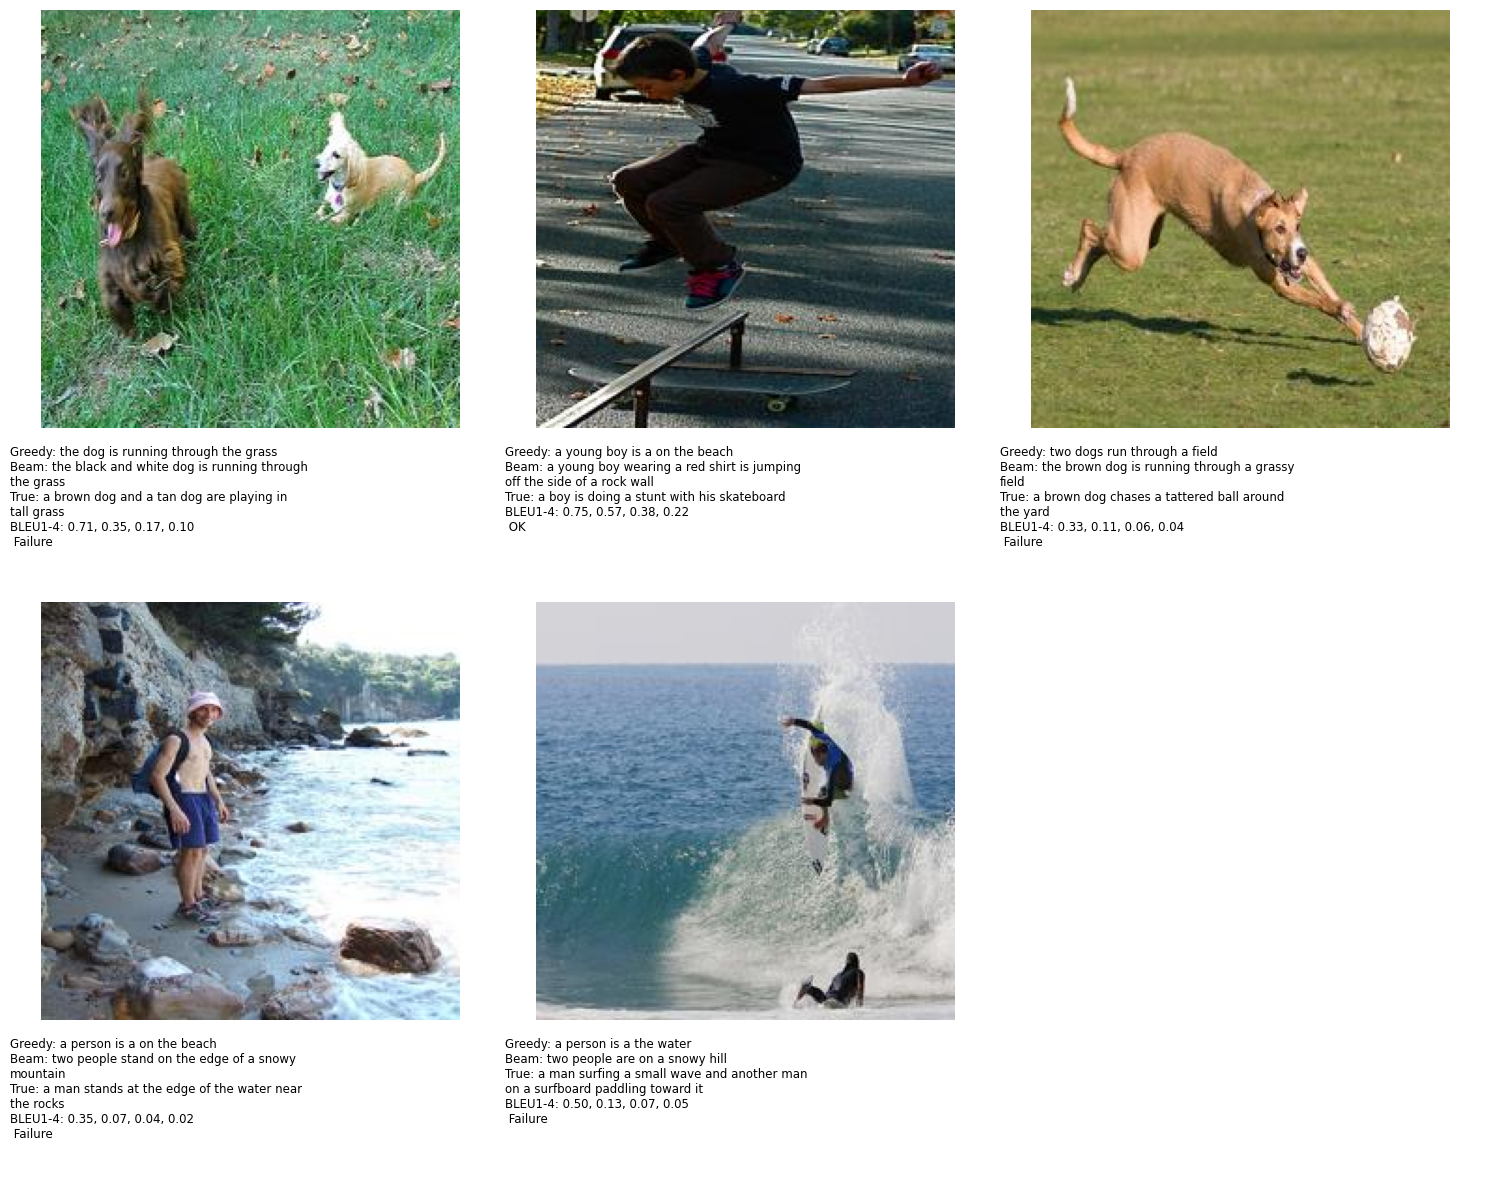

In [ ]:
sample_images = ['1449625950_fc9a8d02d9.jpg','2990977776_1ec51c9281.jpg','778885185_3f6905370b.jpg','2162564553_96de62c7e6.jpg','2930514856_784f17064a.jpg']
image_paths = [f"/content/drive/My Drive/flickr8k/flickr8k_224X224/{img}" for img in sample_images]
display_images(model, image_paths, transform, word2idx, idx2word, gt_captions, device)

In [ ]:
def count_unk_in_captions(model, image_files, transform, word2idx, idx2word, device, method='greedy', max_samples=100):
    model.eval()
    unk_token = "<unk>"
    unk_counts = []

    sampled_files = image_files[:max_samples]
    for fname in tqdm(sampled_files):
        img_path = f"/content/drive/My Drive/flickr8k/flickr8k_224X224/{fname}"
        image = Image.open(img_path).convert("RGB")
        img_tensor = transform(image).unsqueeze(0).to(device)

        if method == 'greedy':
            caption = greedy_search(model, img_tensor.squeeze(0), word2idx, idx2word)
        elif method == 'beam':
            caption = beam_search(model, img_tensor.squeeze(0), word2idx, idx2word, beam_width=5)
        else:
            raise ValueError("method should be 'greedy' or 'beam'")

        unk_count = caption.split().count(unk_token)
        unk_counts.append(unk_count)

    avg_unk = sum(unk_counts) / len(unk_counts)
    total_unk = sum(unk_counts)
    print(f" تعداد کل <unk>: {total_unk} در {len(unk_counts)} کپشن")
    print(f" میانگین <unk> در هر کپشن: {avg_unk:.2f}")

    return unk_counts


In [ ]:
# بررسی برای Greedy
unk_greedy = count_unk_in_captions(model, test_image_files, transform, word2idx, idx2word, device, method='greedy')

# بررسی برای Beam
unk_beam = count_unk_in_captions(model, test_image_files, transform, word2idx, idx2word, device, method='beam')


100%|██████████| 100/100 [00:03<00:00, 31.07it/s]


 تعداد کل <unk>: 0 در 100 کپشن
 میانگین <unk> در هر کپشن: 0.00


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]

 تعداد کل <unk>: 0 در 100 کپشن
 میانگین <unk> در هر کپشن: 0.00


#امتیازی

In [ ]:
def compare_greedy_beam_bleu(model, test_image_files, gt_captions, transform, word2idx, idx2word, device, num_samples=50):
    model.eval()
    records = []

    sampled_files = test_image_files[:num_samples]
    for fname in tqdm(sampled_files):
        img_path = f"/content/drive/My Drive/flickr8k/flickr8k_224X224/{fname}"
        image = Image.open(img_path).convert("RGB")
        img_tensor = transform(image).unsqueeze(0).to(device)

        greedy_cap = greedy_search(model, img_tensor.squeeze(0), word2idx, idx2word)
        beam_cap   = beam_search(model, img_tensor.squeeze(0), word2idx, idx2word, beam_width=5)

        if fname not in gt_captions:
            continue

        references = gt_captions[fname]
        greedy_tokens = greedy_cap.lower().split()
        beam_tokens = beam_cap.lower().split()

        b1_g, b2_g, b3_g, b4_g = compute_bleu_scores(greedy_tokens, references)
        b1_b, b2_b, b3_b, b4_b = compute_bleu_scores(beam_tokens, references)

        records.append({
            "Image": fname,
            "Ground Truth Captions": "\n".join(gt_captions[fname]),
            "Greedy Caption": greedy_cap,
            "Beam Caption": beam_cap,
            "BLEU-1 (Greedy)": round(b1_g, 4),
            "BLEU-2 (Greedy)": round(b2_g, 4),
            "BLEU-3 (Greedy)": round(b3_g, 4),
            "BLEU-4 (Greedy)": round(b4_g, 4),
            "BLEU-1 (Beam)": round(b1_b, 4),
            "BLEU-2 (Beam)": round(b2_b, 4),
            "BLEU-3 (Beam)": round(b3_b, 4),
            "BLEU-4 (Beam)": round(b4_b, 4),

        })

    df = pd.DataFrame(records)
    print(" میانگین BLEU:")
    print(df[["BLEU-1 (Greedy)", "BLEU-1 (Beam)", "BLEU-4 (Greedy)", "BLEU-4 (Beam)"]].mean())

    return df


In [ ]:
bleu_comparison_df = compare_greedy_beam_bleu(model, test_image_files, gt_captions, transform, word2idx, idx2word, device, num_samples=100)
bleu_comparison_df.head(50)

100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


 میانگین BLEU:
BLEU-1 (Greedy)    0.452975
BLEU-1 (Beam)      0.432425
BLEU-4 (Greedy)    0.086378
BLEU-4 (Beam)      0.083946
dtype: float64


,Image,Ground Truth Captions,Greedy Caption,Beam Caption,BLEU-1 (Greedy),BLEU-2 (Greedy),BLEU-3 (Greedy),BLEU-4 (Greedy),BLEU-1 (Beam),BLEU-2 (Beam),BLEU-3 (Beam),BLEU-4 (Beam)
0,3638178504_be1ff246bd.jpg,a little girl is looking at the two horses on ...,two dogs play with a toy in the grass,two dogs play with a tennis ball in its mouth,0.4444,0.1105,0.0576,0.0364,0.3000,0.0876,0.0480,0.0309
1,2337809114_899ba61330.jpg,a boy and girl are placing a red blindfold ove...,two young girls are a in the street,the man in a white shirt is sitting on the sid...,0.5000,0.2673,0.1353,0.0847,0.1818,0.0660,0.0387,0.0257
2,3169591322_d0b6d0cd04.jpg,a man performs a skateboard trick in a parking...,a person is a on the edge of a mountain,two people are on the edge of a snowy mountain,0.8000,0.4216,0.1723,0.0958,0.4000,0.2108,0.1086,0.0677
3,2423085253_6c19149855.jpg,a child running outside with a bright colored ...,two young boys playing in a field,two young boys playing in the grass,0.2420,0.1509,0.0794,0.0512,0.3227,0.2465,0.1900,0.1172
4,2597873827_a5cb3e57ba.jpg,a boy in shorts kneeling on a tile courtyard a...,the young boy is a the air,a young girl wearing a pink shirt and jeans is...,0.7143,0.4880,0.2100,0.1225,0.5294,0.0968,0.0446,0.0259
5,3356284586_21c6f155a5.jpg,an asian girl is standing in a crowd wearing r...,two young girls are playing in a pool,a young girl wearing a pink shirt is holding u...,0.2500,0.1890,0.1074,0.0712,0.4167,0.0970,0.0489,0.0300
6,2999638340_75bc8b165d.jpg,a brown dog is laying in the snow\na brown dog...,the dog is running through the water,a white dog is running through the water,0.4286,0.2673,0.1406,0.0907,0.5000,0.2673,0.1353,0.0847
7,1449625950_fc9a8d02d9.jpg,a brown dog and a tan dog are playing in tall ...,the dog is running through the grass,the black and white dog is running through a g...,0.7143,0.3450,0.1667,0.1030,0.7471,0.4524,0.2748,0.1544
8,3372215826_b3e6403b2e.jpg,a man in a dark hat shoots a handgun\na man sh...,the man is a red shirt is holding a camera,the man wearing a blue shirt is standing on fr...,0.4000,0.1012,0.0528,0.0332,0.2857,0.0762,0.0400,0.0249
9,2930514856_784f17064a.jpg,a man surfing a small wave and another man on ...,the man is a the water,two people are on the beach of a lake,0.5000,0.1339,0.0738,0.0495,0.4971,0.1105,0.0556,0.0344
